In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
# sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/spaghetti/src
/home/akarsh_sakana_ai/.conda/envs/spaghetti/bin/python


In [2]:
import os, sys, glob, pickle, copy, time
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
from einop import einop

import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [336]:
import neat
from neat.reporting import ReporterSet

In [343]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction, neat.DefaultSpeciesSet, neat.DefaultStagnation, "./neat_config.txt")

In [344]:
print(config.genome_config.activation_options)

['sigmoid', 'abs', 'tanh', 'gauss', 'sin', 'identity']


In [345]:
reporters = ReporterSet()
stagnation = config.stagnation_type(config.stagnation_config, reporters)
reproduction = config.reproduction_type(config.reproduction_config, reporters, stagnation)

In [346]:
gs = reproduction.create_new(config.genome_type, config.genome_config, config.pop_size)
gs = list(gs.values())

In [347]:
def hsv2rgb(hsv):
    h, s, v = hsv
    h = h * 360.

    c = v * s
    x = c * (1 - jnp.abs((h / 60) % 2 - 1))
    m = v - c
    rgbp1, c1 = jnp.stack([c, x, 0], axis=-1), (0 <= h)*(h<60)
    rgbp2, c2 = jnp.stack([x, c, 0], axis=-1), (60 <= h)*(h<120)
    rgbp3, c3 = jnp.stack([0, c, x], axis=-1), (120 <= h)*(h<180)
    rgbp4, c4 = jnp.stack([0, x, c], axis=-1), (180 <= h)*(h<240)
    rgbp5, c5 = jnp.stack([x, 0, c], axis=-1), (240 <= h)*(h<300)
    rgbp6, c6 = jnp.stack([c, 0, x], axis=-1), (300 <= h)*(h<360)
    rgbp = rgbp1 * c1 + rgbp2 * c2 + rgbp3 * c3 + rgbp4 * c4 + rgbp5 * c5 + rgbp6 * c6
    rgb = rgbp + m
    return rgb.clip(0., 1.)

def get_image(g):
    net = neat.nn.FeedForwardNetwork.create(g, config)
    x = np.linspace(-10, 10, 64)
    y = np.linspace(-10, 10, 64)
    x, y = np.meshgrid(x, y, indexing='ij')
    d = np.sqrt(x**2 + y**2)
    xyd = np.stack([x, y, d], axis=-1)
    xyd = xyd.reshape((-1, 3))
    hsv = np.stack([net.activate(xydi) for xydi in xyd])
    hsv = hsv.reshape((64, 64, 3))
    hsv = jax.nn.sigmoid(hsv)
    # rgb = hsv
    rgb = jax.vmap(jax.vmap(hsv2rgb))(hsv)
    rgb = np.array(rgb)
    return rgb

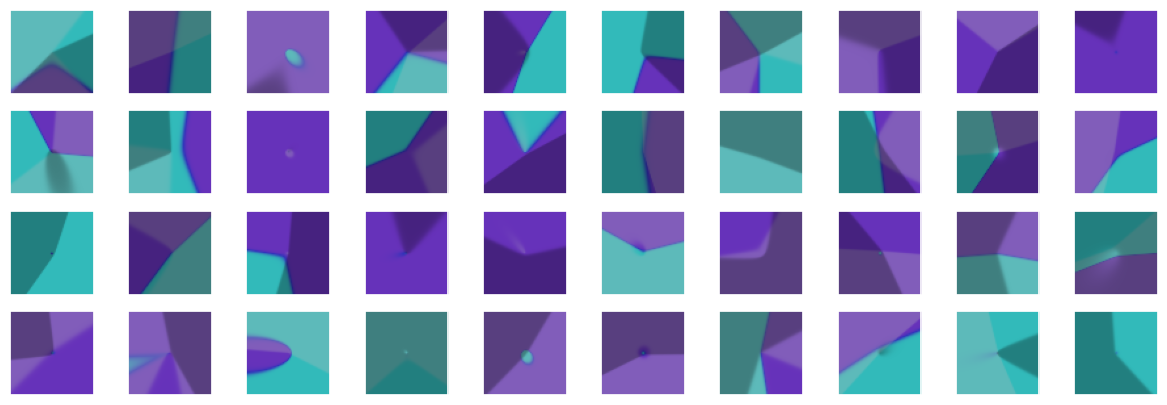

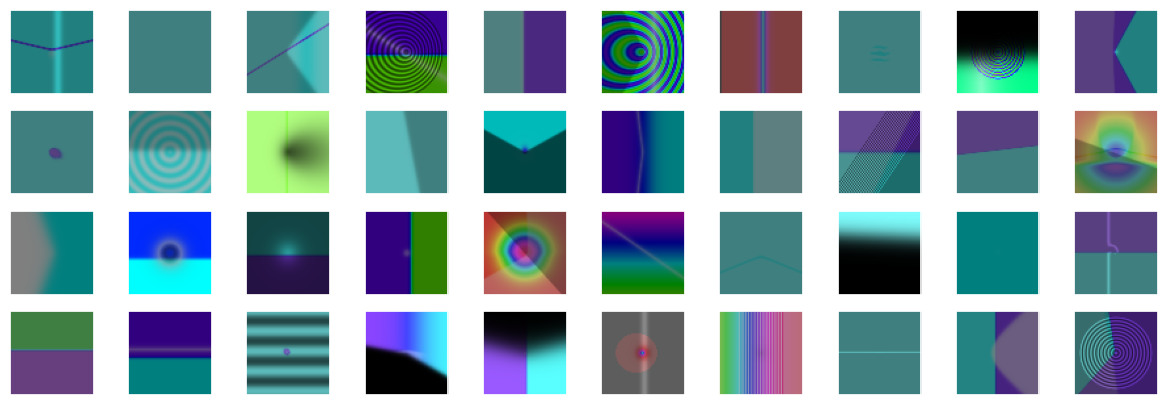

In [348]:
plt.figure(figsize=(15, 5))
for i, g in enumerate(gs[:40]):
    rgb = get_image(g)
    plt.subplot(4, 10, i+1)
    plt.imshow(rgb); plt.grid(False); plt.xticks([]); plt.yticks([])
plt.show()

for g in gs[:40]:
    for i in range(10):
        g.mutate(config.genome_config)

plt.figure(figsize=(15, 5))
for i, g in enumerate(gs[:40]):
    rgb = get_image(g)
    plt.subplot(4, 10, i+1)
    plt.imshow(rgb); plt.grid(False); plt.xticks([]); plt.yticks([])
plt.show()

In [320]:
g = gs[0]
print(g)

Key: 1
Fitness: None
Nodes:
	0 DefaultNodeGene(key=0, bias=0.8879007085006516, response=1.0, activation=tanh, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-0.0466213842787202, response=1.0, activation=tanh, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=1.601975574536171, response=1.0, activation=abs, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=0.5679979408468737, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-3, 0), weight=2.8825464513990773, enabled=False)
	DefaultConnectionGene(key=(-3, 1), weight=1.0123361840285086, enabled=True)
	DefaultConnectionGene(key=(-3, 4), weight=0.43943952763639094, enabled=True)
	DefaultConnectionGene(key=(-2, 0), weight=-1.4858981061048568, enabled=True)
	DefaultConnectionGene(key=(-2, 4), weight=-0.6500127559586727, enabled=True)
	DefaultConnectionGene(key=(-1, 0), weight=-0.8595538060306896, enabled=True)
	DefaultConnectionGene(key=(4, 0), weight=3.242004342800895, enabled=True)


In [321]:
for n in g.nodes.values():
    print(n)

DefaultNodeGene(key=0, bias=0.8879007085006516, response=1.0, activation=tanh, aggregation=sum)
DefaultNodeGene(key=1, bias=-0.0466213842787202, response=1.0, activation=tanh, aggregation=sum)
DefaultNodeGene(key=2, bias=1.601975574536171, response=1.0, activation=abs, aggregation=sum)
DefaultNodeGene(key=4, bias=0.5679979408468737, response=1.0, activation=sigmoid, aggregation=sum)


In [ ]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(xor_inputs, xor_outputs):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2

In [110]:
"""
2-input XOR example -- this is most likely the simplest possible example.
"""

import os

import neat
# import visualize

# 2-input XOR inputs and expected outputs.
xor_inputs = [(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)]
xor_outputs = [(0.0,), (1.0,), (1.0,), (0.0,)]


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(xor_inputs, xor_outputs):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2


def run(config_file):
    print('starting')
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 300)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(xor_inputs, xor_outputs):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
    # visualize.draw_net(config, winner, True, node_names=node_names)
    # visualize.draw_net(config, winner, True, node_names=node_names, prune_unused=True)
    # visualize.plot_stats(stats, ylog=False, view=True)
    # visualize.plot_species(stats, view=True)

    # p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    # p.run(eval_genomes, 10)
    return winner, winner_net


if __name__ == '__main__':
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
    winner, winner_net = run('./neat_config.txt')


starting

 ****** Running generation 0 ****** 

Population's average fitness: 2.27001 stdev: 0.34200
Best fitness: 2.99590 - size: (1, 2) - species 1 - id 21
Average adjusted fitness: 0.602
Mean genetic distance 1.224, standard deviation 0.507
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150      3.0    0.602     0
Total extinctions: 0
Generation time: 0.005 sec

 ****** Running generation 1 ****** 

Population's average fitness: 2.28695 stdev: 0.34981
Best fitness: 2.99796 - size: (1, 2) - species 1 - id 283
Average adjusted fitness: 0.609
Mean genetic distance 1.295, standard deviation 0.468
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150      3.0    0.609     0
Total extinctions: 0
Generation time: 0.005 sec (0.005 average)

 ****** Running generation 2 ****** 

Population's average fitness: 2.31136

In [117]:
winner.nodes

{0: <neat.genes.DefaultNodeGene at 0x147db5798820>,
 266: <neat.genes.DefaultNodeGene at 0x147db579bf40>,
 708: <neat.genes.DefaultNodeGene at 0x147db5798ca0>}